# Problem Statement

<font color=darkblue>In business, it is crucial to understand customers'needs and desire in order to provide optimize their customer journey and maximize their potential value to our business. In order to do so, we firstly need to segment our customers into groups that share something in common. With that, only we are able to curate products and services that cater to their needs.<br><br>
Conventional method practice of customer segmentation includes using RFM analysis, customers are assigned a ranking number of 1,2,3,4, or 5 (with 5 being highest) for each RFM parameter. The three scores together are referred to as an RFM "cell" . The database is sorted to determine which customers were "the best customers" in the past, with a cell ranking of "555" being ideal.<br><br>
However, in this project uses unsupervised machine learning approach ie DBSCan,KMean clsutering to segment customers into different groups using other features on top of based on customers RFM score .

# Import Library

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import math
import os
import pydotplus
from IPython.display import Image  
from datetime import datetime

pd.options.display.float_format = '{:.2f}'.format

from datetime import datetime
from datetime import timedelta 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score,davies_bouldin_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs, make_moons
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist



from sklearn.decomposition import PCA

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)



from sklearn import tree
import graphviz

<font color=darkblue> Click here to [here](./Data_Cleaning.ipynb) for Data Cleaning Notebook and [here](./EDA.ipynb) for EDA.

# Import Cleaned Transactional Data

In [2]:
# Read Cleaned DataFrame
sales_df=pd.read_csv('../datasets/sales_df.csv')
sales_df.head()

,Invoice,InvoiceDate,StockCode,Item Description,Price,Quantity,Revenue,Customer ID,Country,Inv_Date,Inv_Time,Yr,Month,MMYY
0,489434,2009-12-01 07:45:00,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,6.95,12,83.40,13085.00,United Kingdom,2009-12-01,07:45:00,2009,12,Dec 09
1,489434,2009-12-01 07:45:00,79323P,PINK CHERRY LIGHTS,6.75,12,81.00,13085.00,United Kingdom,2009-12-01,07:45:00,2009,12,Dec 09
2,489434,2009-12-01 07:45:00,79323W,WHITE CHERRY LIGHTS,6.75,12,81.00,13085.00,United Kingdom,2009-12-01,07:45:00,2009,12,Dec 09
3,489434,2009-12-01 07:45:00,22041,"RECORD FRAME 7"" SINGLE SIZE",2.10,48,100.80,13085.00,United Kingdom,2009-12-01,07:45:00,2009,12,Dec 09
4,489434,2009-12-01 07:45:00,21232,STRAWBERRY CERAMIC TRINKET BOX,1.25,24,30.00,13085.00,United Kingdom,2009-12-01,07:45:00,2009,12,Dec 09


Summry after data cleaning

|Attribute |Original|Final|Reduced by|
|:------|:------|:------|:------|
|No of rows|1,067,371|779,425|26.98%|
|No of Transactions|53,628|36,969|31.06%|
|No of Product Codes|5,305|4,631|12.70%|
|No of Item Description|5,698|4,608|19.12%|
|No of Registered Customers|5,942|5,878|1.07%|
|No of Registered Customers|43|41|4.65%|

# Create a Customer Attribute DataFrame & Features Engineering

In [3]:
sales_df['Inv_Date2']=sales_df['Inv_Date']
sales_df['Price2']=sales_df['Price']
sales_df['Price3']=sales_df['Price']
sales_df['Price4']=sales_df['Price']
sales_df['Price5']=sales_df['Price']
sales_df['MMYY2']=sales_df['MMYY']
sales_df['MMYY3']=sales_df['MMYY']


customer_df=sales_df.groupby('Customer ID').agg({
                                            'Invoice':pd.Series.nunique,
                                            'MMYY2':'nunique',
                                            'MMYY3':'unique',
                                            'Country':'first',
                                            'Quantity':'sum',
                                            'Item Description':pd.Series.nunique,                                           
                                            'Revenue':'sum',                                           
                                            'Price2':'max',
                                            'Price3':'min',
                                            'Price4':'median',                                            
                                            'Inv_Date':'max',
                                            'Inv_Date2':'min'})

customer_df.rename(columns={'Invoice':'Inv_Count','MMYY2':'No_of_Months_Transac','MMYY3':'Unique MMYY','Country':'Country','Quantity':'Total_Qty','Item Description':'Number_of_Item_Types','Revenue':'Total_Spending','Inv_Date':'Last_Purchase_Date','Inv_Date2':'First_Purchase_Date','Price2':'Max_Item_UnitPrice','Price3':'Min_Item_UnitPrice','Price4':'Median_Item_UnitPrice'},inplace=True)
customer_df.reset_index(inplace=True)
print('There are in total ',len(customer_df),'unique customers.')
customer_df.head(5)

There are in total  5878 unique customers.


,Customer ID,Inv_Count,No_of_Months_Transac,Unique MMYY,Country,Total_Qty,Number_of_Item_Types,Total_Spending,Max_Item_UnitPrice,Min_Item_UnitPrice,Median_Item_UnitPrice,Last_Purchase_Date,First_Purchase_Date
0,12346.00,12,5,"[Dec 09, Jan 10, Mar 10, Jun 10, Jan 11]",United Kingdom,74285,26,77556.46,7.49,1.00,7.49,2011-01-18,2009-12-14
1,12347.00,8,8,"[Oct 10, Dec 10, Jan 11, Apr 11, Jun 11, Aug 1...",Iceland,2967,126,4921.53,12.75,0.25,1.95,2011-12-07,2010-10-31
2,12348.00,5,5,"[Sep 10, Dec 10, Jan 11, Apr 11, Sep 11]",Finland,2714,28,2019.40,40.00,0.29,0.55,2011-09-25,2010-09-27
3,12349.00,4,4,"[Apr 10, May 10, Oct 10, Nov 11]",Italy,1624,145,4428.69,300.00,0.42,2.55,2011-11-21,2010-04-29
4,12350.00,1,1,[Feb 11],Norway,197,17,334.40,40.00,0.85,1.65,2011-02-02,2011-02-02


In [4]:
# Date range of observation
sales_df['InvoiceDate']=pd.to_datetime(sales_df['InvoiceDate'])
print('This dataframe consist data from ', sales_df['InvoiceDate'].min())
print('This dataframe consist data ends on ', sales_df['InvoiceDate'].max())

numofdays=sales_df['InvoiceDate'].max()-sales_df['InvoiceDate'].min()
print('There are in total ',numofdays,'days of observations. ')

This dataframe consist data from  2009-12-01 07:45:00
This dataframe consist data ends on  2011-12-09 12:50:00
There are in total  738 days 05:05:00 days of observations. 


In [5]:
unique_mmyytemp= pd.DataFrame(customer_df['Unique MMYY'].tolist())
unique_mmyytemp.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,Dec 09,Jan 10,Mar 10,Jun 10,Jan 11,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Oct 10,Dec 10,Jan 11,Apr 11,Jun 11,Aug 11,Oct 11,Dec 11,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


<font color=darkblue> The duration of the dataset is for 25 months.

In [6]:
# change 'Last_Purchase_Date','First_Purchase_Date' data type

todatetime=['Last_Purchase_Date','First_Purchase_Date']

customer_df[todatetime]=customer_df[todatetime].apply(pd.to_datetime, format='%Y-%m-%d',errors='coerce')

customer_df.head(2)

,Customer ID,Inv_Count,No_of_Months_Transac,Unique MMYY,Country,Total_Qty,Number_of_Item_Types,Total_Spending,Max_Item_UnitPrice,Min_Item_UnitPrice,Median_Item_UnitPrice,Last_Purchase_Date,First_Purchase_Date
0,12346.00,12,5,"[Dec 09, Jan 10, Mar 10, Jun 10, Jan 11]",United Kingdom,74285,26,77556.46,7.49,1.00,7.49,2011-01-18,2009-12-14
1,12347.00,8,8,"[Oct 10, Dec 10, Jan 11, Apr 11, Jun 11, Aug 1...",Iceland,2967,126,4921.53,12.75,0.25,1.95,2011-12-07,2010-10-31


In [7]:
# Adding columns: Tenure (in days), Avg_Spening_Per_inv,Avg_Purchase_Qty_Per_Inv,Avg_Item_Types_Per_Inv,Avg_UnitPrice_Per_Item

customer_df['Avg_Transaction_Per_Mth']=customer_df['Inv_Count']/25
customer_df['Avg_Spending_Per_Mth']=customer_df['Total_Spending']/25

customer_df['Ratio_Transaction_Per_Unique_Mth']=customer_df['Inv_Count']/customer_df['No_of_Months_Transac']
customer_df['Ratio_Spending_Per_Unique_Mth']=customer_df['Total_Spending']/customer_df['No_of_Months_Transac']



customer_df['Avg_Spending_Per_Inv']=customer_df['Total_Spending']/customer_df['Inv_Count']
customer_df['Avg_Purchase_Qty_Per_Inv']=customer_df['Total_Qty']/customer_df['Inv_Count']
customer_df['Avg_Item_Types_Per_Inv']=customer_df['Number_of_Item_Types']/customer_df['Inv_Count']
customer_df.head(2)

,Customer ID,Inv_Count,No_of_Months_Transac,Unique MMYY,Country,Total_Qty,Number_of_Item_Types,Total_Spending,Max_Item_UnitPrice,Min_Item_UnitPrice,Median_Item_UnitPrice,Last_Purchase_Date,First_Purchase_Date,Avg_Transaction_Per_Mth,Avg_Spending_Per_Mth,Ratio_Transaction_Per_Unique_Mth,Ratio_Spending_Per_Unique_Mth,Avg_Spending_Per_Inv,Avg_Purchase_Qty_Per_Inv,Avg_Item_Types_Per_Inv
0,12346.00,12,5,"[Dec 09, Jan 10, Mar 10, Jun 10, Jan 11]",United Kingdom,74285,26,77556.46,7.49,1.00,7.49,2011-01-18,2009-12-14,0.48,3102.26,2.40,15511.29,6463.04,6190.42,2.17
1,12347.00,8,8,"[Oct 10, Dec 10, Jan 11, Apr 11, Jun 11, Aug 1...",Iceland,2967,126,4921.53,12.75,0.25,1.95,2011-12-07,2010-10-31,0.32,196.86,1.00,615.19,615.19,370.88,15.75


In [8]:
# # change 'Tenure' data type to Integer
# customer_df['Tenure']=pd.to_numeric(customer_df['Tenure'].dt.days,downcast='integer')

In [9]:
# using last invoice date +1 day as cut-off refernce for recentcy
offset=timedelta(days=1)
cutoffdate=pd.to_datetime(sales_df['InvoiceDate'].max(),format='%Y-%m-%d',errors='coerce')+offset
print(cutoffdate)

2011-12-10 12:50:00


In [10]:
# # Add 1 day for Tenuere also
# customer_df['Tenure']=customer_df['Tenure']+1
# #customer_df.sort_values(by="Inv_Count", ascending=False).head()
# customer_df.head(2)

In [11]:
# Create columns Recency, Frequency & Monetary
customer_df['Recency'] = customer_df['Last_Purchase_Date'].apply(lambda x: (cutoffdate - x).days)
customer_df['Tenure'] = customer_df['First_Purchase_Date'].apply(lambda x: (cutoffdate - x).days)
customer_df['Frequency']=customer_df['Inv_Count']
customer_df['Monetary']=customer_df['Total_Spending']
customer_df.head(2)

,Customer ID,Inv_Count,No_of_Months_Transac,Unique MMYY,Country,Total_Qty,Number_of_Item_Types,Total_Spending,Max_Item_UnitPrice,Min_Item_UnitPrice,Median_Item_UnitPrice,Last_Purchase_Date,First_Purchase_Date,Avg_Transaction_Per_Mth,Avg_Spending_Per_Mth,Ratio_Transaction_Per_Unique_Mth,Ratio_Spending_Per_Unique_Mth,Avg_Spending_Per_Inv,Avg_Purchase_Qty_Per_Inv,Avg_Item_Types_Per_Inv,Recency,Tenure,Frequency,Monetary
0,12346.00,12,5,"[Dec 09, Jan 10, Mar 10, Jun 10, Jan 11]",United Kingdom,74285,26,77556.46,7.49,1.00,7.49,2011-01-18,2009-12-14,0.48,3102.26,2.40,15511.29,6463.04,6190.42,2.17,326,726,12,77556.46
1,12347.00,8,8,"[Oct 10, Dec 10, Jan 11, Apr 11, Jun 11, Aug 1...",Iceland,2967,126,4921.53,12.75,0.25,1.95,2011-12-07,2010-10-31,0.32,196.86,1.00,615.19,615.19,370.88,15.75,3,405,8,4921.53


In [12]:
# rearrange Tenure to the last column 
col_last=['Tenure']

customer_df=customer_df[[c for c in customer_df.columns if c not in col_last]+ [c for c in col_last]]
customer_df.head(2)

,Customer ID,Inv_Count,No_of_Months_Transac,Unique MMYY,Country,Total_Qty,Number_of_Item_Types,Total_Spending,Max_Item_UnitPrice,Min_Item_UnitPrice,Median_Item_UnitPrice,Last_Purchase_Date,First_Purchase_Date,Avg_Transaction_Per_Mth,Avg_Spending_Per_Mth,Ratio_Transaction_Per_Unique_Mth,Ratio_Spending_Per_Unique_Mth,Avg_Spending_Per_Inv,Avg_Purchase_Qty_Per_Inv,Avg_Item_Types_Per_Inv,Recency,Frequency,Monetary,Tenure
0,12346.00,12,5,"[Dec 09, Jan 10, Mar 10, Jun 10, Jan 11]",United Kingdom,74285,26,77556.46,7.49,1.00,7.49,2011-01-18,2009-12-14,0.48,3102.26,2.40,15511.29,6463.04,6190.42,2.17,326,12,77556.46,726
1,12347.00,8,8,"[Oct 10, Dec 10, Jan 11, Apr 11, Jun 11, Aug 1...",Iceland,2967,126,4921.53,12.75,0.25,1.95,2011-12-07,2010-10-31,0.32,196.86,1.00,615.19,615.19,370.88,15.75,3,8,4921.53,405


In [13]:
# for Recency, the higher the number, the lower the ratings
def recency_score(x):
    if x<=customer_df['Recency'].quantile(0.2):
        return 5
    elif x<=customer_df['Recency'].quantile(0.4):
        return 4
    elif x<=customer_df['Recency'].quantile(0.6):
        return 3
    elif x<=customer_df['Recency'].quantile(0.8):
        return 2
    else: 
        return 1
    

# for Frequency, the higher the number, the higher the ratings
def frequency_score(x):
    if x<=customer_df['Frequency'].quantile(0.2):
        return 1
    elif x<=customer_df['Frequency'].quantile(0.4):
        return 2
    elif x<=customer_df['Frequency'].quantile(0.6):
        return 3
    elif x<=customer_df['Frequency'].quantile(0.8):
        return 4
    else: 
        return 5
    

# for Monetary, the higher the number, the higher the ratings
def monetary_score(x):
    if x<=customer_df['Monetary'].quantile(0.2):
        return 1
    elif x<=customer_df['Monetary'].quantile(0.4):
        return 2
    elif x<=customer_df['Monetary'].quantile(0.6):
        return 3
    elif x<=customer_df['Monetary'].quantile(0.8):
        return 4
    else: 
        return 5
    
# for Tenure, the higher the number, the higher the ratings
def tenure_score(x):
    if x<=customer_df['Tenure'].quantile(0.2):
        return 1
    elif x<=customer_df['Tenure'].quantile(0.4):
        return 2
    elif x<=customer_df['Tenure'].quantile(0.6):
        return 3
    elif x<=customer_df['Tenure'].quantile(0.8):
        return 4
    else: 
        return 5

In [14]:
customer_df['Recency_Score']=customer_df['Recency'].apply(recency_score)
customer_df['Frequency_Score']=customer_df['Frequency'].apply(frequency_score)
customer_df['Monetary_Score']=customer_df['Monetary'].apply(monetary_score)
customer_df['Tenure_Score']=customer_df['Tenure'].apply(tenure_score)

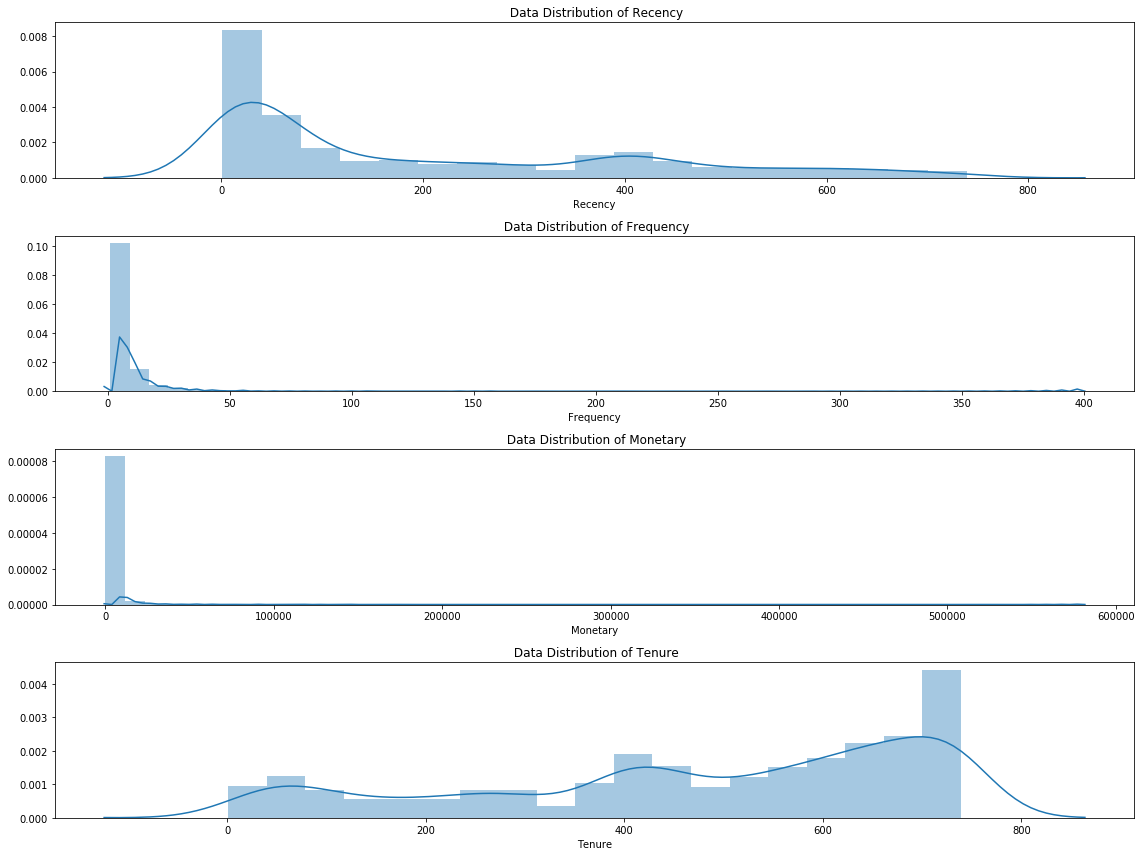

In [15]:
# Data Distribution

plt.figure(figsize=(16,12))



plt.subplot(4,1,1);sns.distplot(customer_df['Recency'])
plt.title(' Data Distribution of Recency')

plt.subplot(4,1,2); sns.distplot(customer_df['Frequency'])
plt.title(' Data Distribution of Frequency')

plt.subplot(4,1,3); sns.distplot(customer_df['Monetary'])
plt.title(' Data Distribution of Monetary')

plt.subplot(4,1,4); sns.distplot(customer_df['Tenure'])
plt.title(' Data Distribution of Tenure')


plt.tight_layout()


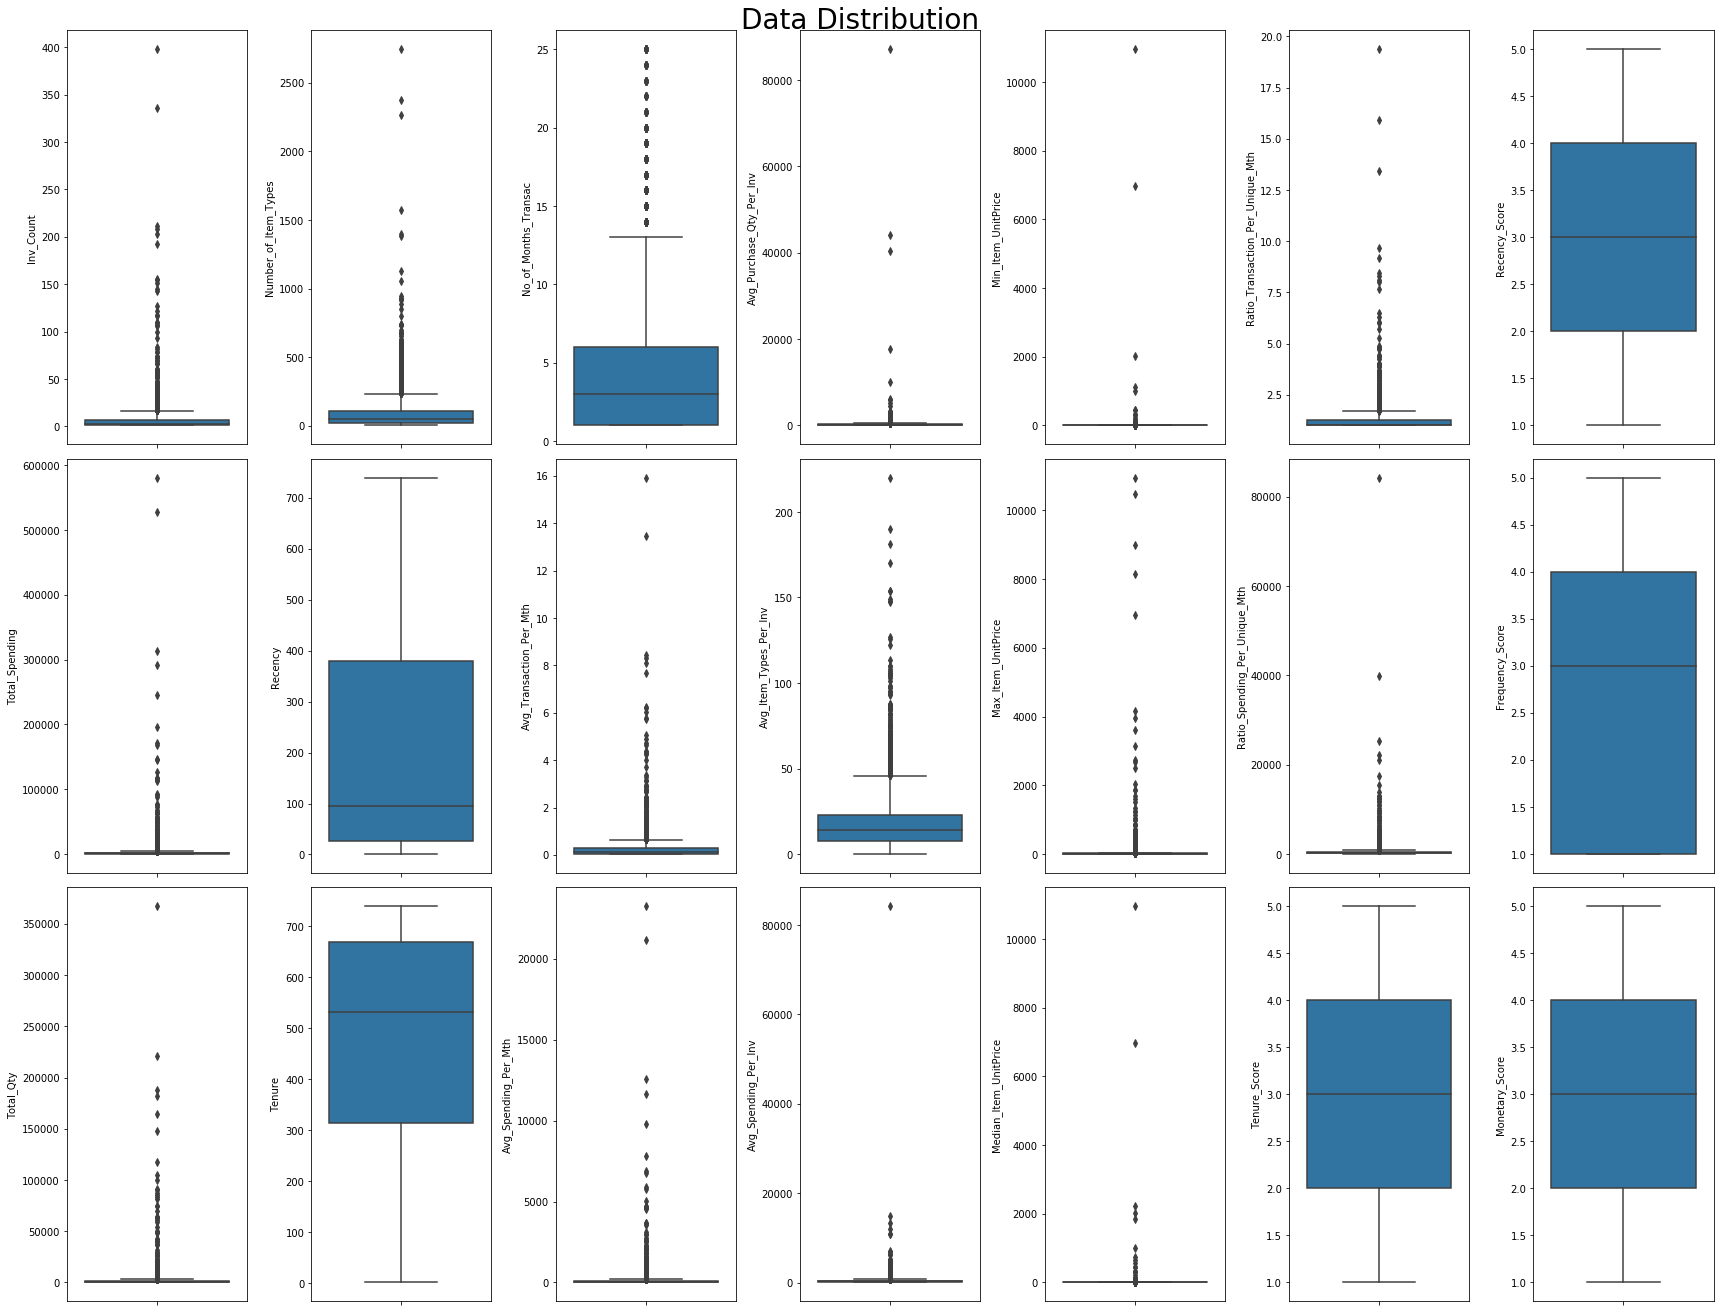

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(24,18))
fig.suptitle('Data Distribution',x=0.5, y=1.01, horizontalalignment='center', verticalalignment='top', fontsize = 28)

ax_0=sns.boxplot(y="Inv_Count",data=customer_df,  orient='v' , ax=axes[0][0])
ax_1=sns.boxplot(y="Total_Spending",data=customer_df,  orient='v' , ax=axes[1][0])
ax_2=sns.boxplot(y="Total_Qty",data=customer_df,  orient='v' , ax=axes[2][0])

ax_3=sns.boxplot(y="Number_of_Item_Types", data=customer_df,  orient='v' , ax=axes[0][1])
ax_4=sns.boxplot(y="Recency", data=customer_df,  orient='v' , ax=axes[1][1])
ax_5=sns.boxplot(y="Tenure",data=customer_df,  orient='v' , ax=axes[2][1])

ax_6=sns.boxplot(y="No_of_Months_Transac",  data=customer_df,  orient='v' , ax=axes[0][2])
ax_7=sns.boxplot(y="Avg_Transaction_Per_Mth",  data=customer_df,  orient='v' , ax=axes[1][2])
ax_8=sns.boxplot(y="Avg_Spending_Per_Mth",  data=customer_df,  orient='v' , ax=axes[2][2])

ax_9=sns.boxplot(y="Avg_Purchase_Qty_Per_Inv",data=customer_df,  orient='v' , ax=axes[0][3])
ax_10=sns.boxplot(y="Avg_Item_Types_Per_Inv",data=customer_df,  orient='v' , ax=axes[1][3])
ax_11=sns.boxplot(y="Avg_Spending_Per_Inv",data=customer_df,  orient='v' , ax=axes[2][3])


ax_12=sns.boxplot(y="Min_Item_UnitPrice", data=customer_df,  orient='v' , ax=axes[0][4])
ax_13=sns.boxplot(y="Max_Item_UnitPrice", data=customer_df,  orient='v' , ax=axes[1][4])
ax_14=sns.boxplot(y="Median_Item_UnitPrice",data=customer_df,  orient='v' , ax=axes[2][4])


ax_9=sns.boxplot(y="Ratio_Transaction_Per_Unique_Mth", data=customer_df,  orient='v' , ax=axes[0][5])
ax_10=sns.boxplot(y="Ratio_Spending_Per_Unique_Mth",data=customer_df,  orient='v' , ax=axes[1][5])
ax_11=sns.boxplot(y="Tenure_Score",data=customer_df,  orient='v' , ax=axes[2][5])


ax_12=sns.boxplot(y="Recency_Score", data=customer_df,  orient='v' , ax=axes[0][6])
ax_13=sns.boxplot(y="Frequency_Score",data=customer_df,  orient='v' , ax=axes[1][6])
ax_14=sns.boxplot(y="Monetary_Score",data=customer_df,  orient='v' , ax=axes[2][6])


fig.tight_layout();

<font color=darkblue> The data distribution is not normally distributed with most of them are skewed to the right.<br>
However, in this project, the data will not be log transformed as it will lead.

<font color=darkblue>The concept of recency, frequency, monetary value (RFM) is thought to date from an article by Jan Roelf Bult and Tom Wansbeek, "Optimal Selection for Direct Mail," published in a 1995 issue of Marketing Science. (Investopedia)
RFM analysis is based on the marketing axiom that "80% of your business comes from 20% of your customers. (Pareto Rule).
One well-known commercial approach uses five bins per attributes, which yields 125 segments. (Wikipedia)<br>
Using RFM analysis, customers are assigned a ranking number of 1,2,3,4, or 5 (with 5 being highest) for each RFM parameter. The three scores together are referred to as an RFM "cell" . The database is sorted to determine which customers were "the best customers" in the past, with a cell ranking of "555" being ideal.(Searchdatamanagement)

In [17]:
# Putting all score into one column RFM score 
customer_df['RFM_Score']=customer_df['Recency_Score'].map(str)\
                    +customer_df['Frequency_Score'].map(str)\
                    +customer_df['Monetary_Score'].map(str)      

customer_df.head(3)

,Customer ID,Inv_Count,No_of_Months_Transac,Unique MMYY,Country,Total_Qty,Number_of_Item_Types,Total_Spending,Max_Item_UnitPrice,Min_Item_UnitPrice,Median_Item_UnitPrice,Last_Purchase_Date,First_Purchase_Date,Avg_Transaction_Per_Mth,Avg_Spending_Per_Mth,Ratio_Transaction_Per_Unique_Mth,Ratio_Spending_Per_Unique_Mth,Avg_Spending_Per_Inv,Avg_Purchase_Qty_Per_Inv,Avg_Item_Types_Per_Inv,Recency,Frequency,Monetary,Tenure,Recency_Score,Frequency_Score,Monetary_Score,Tenure_Score,RFM_Score
0,12346.00,12,5,"[Dec 09, Jan 10, Mar 10, Jun 10, Jan 11]",United Kingdom,74285,26,77556.46,7.49,1.00,7.49,2011-01-18,2009-12-14,0.48,3102.26,2.40,15511.29,6463.04,6190.42,2.17,326,12,77556.46,726,2,5,5,5,255
1,12347.00,8,8,"[Oct 10, Dec 10, Jan 11, Apr 11, Jun 11, Aug 1...",Iceland,2967,126,4921.53,12.75,0.25,1.95,2011-12-07,2010-10-31,0.32,196.86,1.00,615.19,615.19,370.88,15.75,3,8,4921.53,405,5,4,5,2,545
2,12348.00,5,5,"[Sep 10, Dec 10, Jan 11, Apr 11, Sep 11]",Finland,2714,28,2019.40,40.00,0.29,0.55,2011-09-25,2010-09-27,0.20,80.78,1.00,403.88,403.88,542.80,5.60,76,5,2019.40,439,3,4,4,3,344


In [18]:
# based on RFM_Score there are how many combination
print('There are ',customer_df['RFM_Score'].nunique(),'combinations of RFM_Score')
customer_df['RFM_Score'].value_counts()

There are  113 combinations of RFM_Score


555    468
111    442
211    251
455    237
112    216
344    157
444    143
212    133
544    131
355    131
311    127
222    126
233    123
433    119
333    108
411     93
554     93
533     87
122     87
312     86
334     85
445     75
543     72
244     72
454     70
223     69
322     68
234     67
232     67
133     66
323     65
123     63
343     62
332     62
434     61
121     59
422     59
345     57
243     55
534     54
423     52
432     51
522     51
545     51
443     49
221     48
354     46
412     45
511     42
113     41
523     38
134     37
255     33
532     32
132     31
213     30
512     29
144     28
245     27
321     24
313     23
521     22
421     21
124     21
413     19
224     19
335     18
324     17
254     15
143     13
431     13
435     12
242     11
214     11
331     11
524     11
424     10
314     10
135     10
353      9
114      9
155      9
535      9
145      9
235      8
131      8
342      7
542      6
531      6
513      5
154      5

<font color=darkblue> There are 113 combinations of RFM Score and <br>
- 468 customers has RFM Score 555.<br>
- 442 customers has RFM Score 111<br>

## RFM Value as Features

In [19]:
rfm_data=customer_df[['Customer ID','Recency','Frequency','Monetary']]
rfm_data.set_index('Customer ID',inplace=True)
rfm_data.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00,326,12,77556.46
12347.00,3,8,4921.53
12348.00,76,5,2019.40
12349.00,19,4,4428.69
12350.00,311,1,334.40


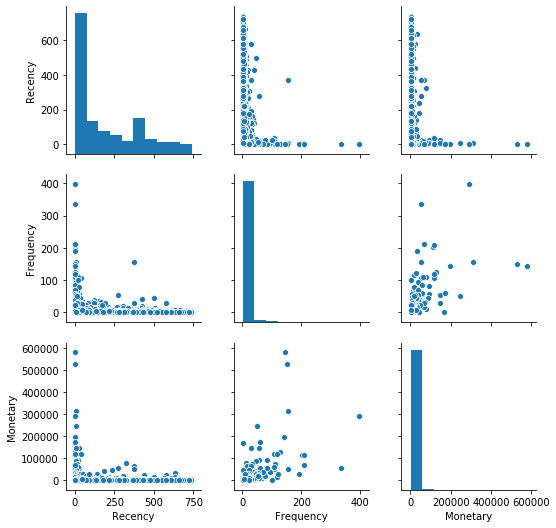

In [20]:
sns.pairplot(rfm_data)

In [21]:
rfm_data.corr()

,Recency,Frequency,Monetary
Recency,1.00,-0.26,-0.13
Frequency,-0.26,1.00,0.63
Monetary,-0.13,0.63,1.00


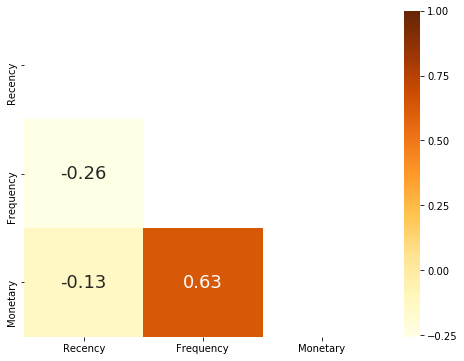

In [22]:
fix, ax = plt.subplots(figsize=(8,6))
mask = np.zeros_like(rfm_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(rfm_data.corr(), mask=mask, cmap='YlOrBr',ax=ax,annot=True,fmt='.2f',annot_kws={"size":18})
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10);

<font color=darkblue> When comparing correlation of Recency, Frequency and Monetary in value:
- Frequency & Monetary shows strong positive correlation <br>
- Monetary & Recency shows negative correlation<br>
- Frequency & Recency shows strong negative correlation.

## Final customer_df

In [23]:
# Check list of country customers from
country_df=customer_df.groupby('Country').agg({'Customer ID':'count'})
country_df.sort_values(by='Customer ID',ascending=False)

,Customer ID
Country,
United Kingdom,5349
Germany,107
France,93
Spain,39
Belgium,27
Portugal,24
Netherlands,22
Switzerland,21
Sweden,19


<font color=darkblue> Will retain country name for the top 10 countries of customer count.<br> The remaining country will be categorized under "Others Countries"

In [24]:
customer_df['Customer_Country']=" "

In [25]:
customer_df.loc[customer_df['Country']=='United Kingdom','Customer_Country']='United Kingdom'
customer_df.loc[customer_df['Country']=='Germany','Customer_Country']='Germany'
customer_df.loc[customer_df['Country']=='France','Customer_Country']='France'
customer_df.loc[customer_df['Country']=='Spain','Customer_Country']='Spain'
customer_df.loc[customer_df['Country']=='Belgium','Customer_Country']='Belgium'
customer_df.loc[customer_df['Country']=='Portugal','Customer_Country']='Portugal'
customer_df.loc[customer_df['Country']=='Netherlands','Customer_Country']='Netherlands'
customer_df.loc[customer_df['Country']=='Switzerland','Customer_Country']='Switzerland'
customer_df.loc[customer_df['Country']=='Sweden','Customer_Country']='Sweden'
customer_df.loc[customer_df['Country']=='Italy','Customer_Country']='Italy'
customer_df.loc[customer_df['Customer_Country']==' ','Customer_Country']='Other Countries'
customer_df.head(3)

,Customer ID,Inv_Count,No_of_Months_Transac,Unique MMYY,Country,Total_Qty,Number_of_Item_Types,Total_Spending,Max_Item_UnitPrice,Min_Item_UnitPrice,Median_Item_UnitPrice,Last_Purchase_Date,First_Purchase_Date,Avg_Transaction_Per_Mth,Avg_Spending_Per_Mth,Ratio_Transaction_Per_Unique_Mth,Ratio_Spending_Per_Unique_Mth,Avg_Spending_Per_Inv,Avg_Purchase_Qty_Per_Inv,Avg_Item_Types_Per_Inv,Recency,Frequency,Monetary,Tenure,Recency_Score,Frequency_Score,Monetary_Score,Tenure_Score,RFM_Score,Customer_Country
0,12346.00,12,5,"[Dec 09, Jan 10, Mar 10, Jun 10, Jan 11]",United Kingdom,74285,26,77556.46,7.49,1.00,7.49,2011-01-18,2009-12-14,0.48,3102.26,2.40,15511.29,6463.04,6190.42,2.17,326,12,77556.46,726,2,5,5,5,255,United Kingdom
1,12347.00,8,8,"[Oct 10, Dec 10, Jan 11, Apr 11, Jun 11, Aug 1...",Iceland,2967,126,4921.53,12.75,0.25,1.95,2011-12-07,2010-10-31,0.32,196.86,1.00,615.19,615.19,370.88,15.75,3,8,4921.53,405,5,4,5,2,545,Other Countries
2,12348.00,5,5,"[Sep 10, Dec 10, Jan 11, Apr 11, Sep 11]",Finland,2714,28,2019.40,40.00,0.29,0.55,2011-09-25,2010-09-27,0.20,80.78,1.00,403.88,403.88,542.80,5.60,76,5,2019.40,439,3,4,4,3,344,Other Countries


In [26]:
customer_df=pd.get_dummies(customer_df,columns=['Customer_Country'])
customer_df.head()

,Customer ID,Inv_Count,No_of_Months_Transac,Unique MMYY,Country,Total_Qty,Number_of_Item_Types,Total_Spending,Max_Item_UnitPrice,Min_Item_UnitPrice,Median_Item_UnitPrice,Last_Purchase_Date,First_Purchase_Date,Avg_Transaction_Per_Mth,Avg_Spending_Per_Mth,Ratio_Transaction_Per_Unique_Mth,Ratio_Spending_Per_Unique_Mth,Avg_Spending_Per_Inv,Avg_Purchase_Qty_Per_Inv,Avg_Item_Types_Per_Inv,Recency,Frequency,Monetary,Tenure,Recency_Score,Frequency_Score,Monetary_Score,Tenure_Score,RFM_Score,Customer_Country_Belgium,Customer_Country_France,Customer_Country_Germany,Customer_Country_Italy,Customer_Country_Netherlands,Customer_Country_Other Countries,Customer_Country_Portugal,Customer_Country_Spain,Customer_Country_Sweden,Customer_Country_Switzerland,Customer_Country_United Kingdom
0,12346.00,12,5,"[Dec 09, Jan 10, Mar 10, Jun 10, Jan 11]",United Kingdom,74285,26,77556.46,7.49,1.00,7.49,2011-01-18,2009-12-14,0.48,3102.26,2.40,15511.29,6463.04,6190.42,2.17,326,12,77556.46,726,2,5,5,5,255,0,0,0,0,0,0,0,0,0,0,1
1,12347.00,8,8,"[Oct 10, Dec 10, Jan 11, Apr 11, Jun 11, Aug 1...",Iceland,2967,126,4921.53,12.75,0.25,1.95,2011-12-07,2010-10-31,0.32,196.86,1.00,615.19,615.19,370.88,15.75,3,8,4921.53,405,5,4,5,2,545,0,0,0,0,0,1,0,0,0,0,0
2,12348.00,5,5,"[Sep 10, Dec 10, Jan 11, Apr 11, Sep 11]",Finland,2714,28,2019.40,40.00,0.29,0.55,2011-09-25,2010-09-27,0.20,80.78,1.00,403.88,403.88,542.80,5.60,76,5,2019.40,439,3,4,4,3,344,0,0,0,0,0,1,0,0,0,0,0
3,12349.00,4,4,"[Apr 10, May 10, Oct 10, Nov 11]",Italy,1624,145,4428.69,300.00,0.42,2.55,2011-11-21,2010-04-29,0.16,177.15,1.00,1107.17,1107.17,406.00,36.25,19,4,4428.69,590,5,3,5,3,535,0,0,0,1,0,0,0,0,0,0,0
4,12350.00,1,1,[Feb 11],Norway,197,17,334.40,40.00,0.85,1.65,2011-02-02,2011-02-02,0.04,13.38,1.00,334.40,334.40,197.00,17.00,311,1,334.40,311,2,1,2,2,212,0,0,0,0,0,1,0,0,0,0,0


In [27]:
print('Shape of customer_df: ',customer_df.shape)

Shape of customer_df:  (5878, 40)


In [28]:
# export customer_df to a csv file 
customer_df.to_csv('../datasets/customer_df.csv',index=False)

In [29]:
# Creating Customer Feature Dataframe
col_not_toinclude=['Inv_Count','Total_Spending','RFM_Score','Recency_Score','Frequency_Score','Monetary_Score','Tenure_Score','Unique MMYY','Country']

customer_feat=customer_df[[c for c in customer_df if c not in col_not_toinclude]]
#customer_feat.set_index('Customer ID',inplace=True)
print('Shape of customer_feat: ',customer_feat.shape)
customer_feat.head()

Shape of customer_feat:  (5878, 31)


,Customer ID,No_of_Months_Transac,Total_Qty,Number_of_Item_Types,Max_Item_UnitPrice,Min_Item_UnitPrice,Median_Item_UnitPrice,Last_Purchase_Date,First_Purchase_Date,Avg_Transaction_Per_Mth,Avg_Spending_Per_Mth,Ratio_Transaction_Per_Unique_Mth,Ratio_Spending_Per_Unique_Mth,Avg_Spending_Per_Inv,Avg_Purchase_Qty_Per_Inv,Avg_Item_Types_Per_Inv,Recency,Frequency,Monetary,Tenure,Customer_Country_Belgium,Customer_Country_France,Customer_Country_Germany,Customer_Country_Italy,Customer_Country_Netherlands,Customer_Country_Other Countries,Customer_Country_Portugal,Customer_Country_Spain,Customer_Country_Sweden,Customer_Country_Switzerland,Customer_Country_United Kingdom
0,12346.00,5,74285,26,7.49,1.00,7.49,2011-01-18,2009-12-14,0.48,3102.26,2.40,15511.29,6463.04,6190.42,2.17,326,12,77556.46,726,0,0,0,0,0,0,0,0,0,0,1
1,12347.00,8,2967,126,12.75,0.25,1.95,2011-12-07,2010-10-31,0.32,196.86,1.00,615.19,615.19,370.88,15.75,3,8,4921.53,405,0,0,0,0,0,1,0,0,0,0,0
2,12348.00,5,2714,28,40.00,0.29,0.55,2011-09-25,2010-09-27,0.20,80.78,1.00,403.88,403.88,542.80,5.60,76,5,2019.40,439,0,0,0,0,0,1,0,0,0,0,0
3,12349.00,4,1624,145,300.00,0.42,2.55,2011-11-21,2010-04-29,0.16,177.15,1.00,1107.17,1107.17,406.00,36.25,19,4,4428.69,590,0,0,0,1,0,0,0,0,0,0,0
4,12350.00,1,197,17,40.00,0.85,1.65,2011-02-02,2011-02-02,0.04,13.38,1.00,334.40,334.40,197.00,17.00,311,1,334.40,311,0,0,0,0,0,1,0,0,0,0,0


In [30]:
# export customer_feat to a csv file 
customer_feat.to_csv('../datasets/customer_feat.csv',index=False)

In [31]:
customer_feat.corr()

,Customer ID,No_of_Months_Transac,Total_Qty,Number_of_Item_Types,Max_Item_UnitPrice,Min_Item_UnitPrice,Median_Item_UnitPrice,Avg_Transaction_Per_Mth,Avg_Spending_Per_Mth,Ratio_Transaction_Per_Unique_Mth,Ratio_Spending_Per_Unique_Mth,Avg_Spending_Per_Inv,Avg_Purchase_Qty_Per_Inv,Avg_Item_Types_Per_Inv,Recency,Frequency,Monetary,Tenure,Customer_Country_Belgium,Customer_Country_France,Customer_Country_Germany,Customer_Country_Italy,Customer_Country_Netherlands,Customer_Country_Other Countries,Customer_Country_Portugal,Customer_Country_Spain,Customer_Country_Sweden,Customer_Country_Switzerland,Customer_Country_United Kingdom
Customer ID,1.00,-0.01,-0.02,0.00,-0.03,-0.01,-0.02,-0.00,-0.01,0.03,-0.03,-0.04,-0.02,-0.00,0.02,-0.00,-0.01,0.03,-0.11,-0.20,-0.21,-0.08,-0.09,-0.20,-0.09,-0.13,-0.08,-0.09,0.45
No_of_Months_Transac,-0.01,1.00,0.37,0.64,0.07,-0.02,-0.02,0.72,0.39,0.35,0.11,0.03,0.01,-0.18,-0.45,0.72,0.39,0.46,0.01,0.02,0.03,-0.01,-0.00,-0.04,-0.02,-0.02,-0.01,-0.01,0.02
Total_Qty,-0.02,0.37,1.00,0.40,0.14,-0.01,-0.01,0.57,0.87,0.43,0.49,0.26,0.36,-0.05,-0.11,0.57,0.87,0.13,-0.00,0.02,0.00,-0.01,0.11,0.06,-0.00,-0.00,0.02,0.00,-0.07
Number_of_Item_Types,0.00,0.64,0.40,1.00,0.08,-0.02,-0.02,0.71,0.42,0.48,0.17,0.05,0.02,0.25,-0.32,0.71,0.42,0.28,-0.00,0.01,0.02,-0.01,0.00,0.02,-0.01,-0.01,-0.02,0.01,-0.01
Max_Item_UnitPrice,-0.03,0.07,0.14,0.08,1.00,0.58,0.60,0.16,0.18,0.17,0.22,0.13,0.01,-0.02,-0.00,0.16,0.18,0.04,0.01,0.04,0.01,0.00,0.00,0.07,0.01,0.01,0.01,0.01,-0.07
Min_Item_UnitPrice,-0.01,-0.02,-0.01,-0.02,0.58,1.00,0.99,-0.01,0.01,0.01,0.14,0.14,-0.00,-0.03,0.04,-0.01,0.01,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,0.04,0.00,0.00,-0.00,-0.00,-0.02
Median_Item_UnitPrice,-0.02,-0.02,-0.01,-0.02,0.60,0.99,1.00,-0.01,0.01,0.02,0.16,0.14,-0.01,-0.03,0.05,-0.01,0.01,0.01,-0.00,0.01,-0.00,-0.00,-0.00,0.04,-0.00,0.00,-0.00,-0.00,-0.02
Avg_Transaction_Per_Mth,-0.00,0.72,0.57,0.71,0.16,-0.01,-0.01,1.00,0.63,0.75,0.23,0.03,0.01,-0.14,-0.26,1.00,0.63,0.27,-0.00,0.00,0.01,-0.01,0.02,0.01,-0.01,-0.02,-0.00,-0.01,-0.00
Avg_Spending_Per_Mth,-0.01,0.39,0.87,0.42,0.18,0.01,0.01,0.63,1.00,0.48,0.56,0.27,0.13,-0.06,-0.13,0.63,1.00,0.13,-0.00,0.01,0.01,-0.00,0.09,0.05,-0.00,-0.00,0.01,0.01,-0.06
Ratio_Transaction_Per_Unique_Mth,0.03,0.35,0.43,0.48,0.17,0.01,0.02,0.75,0.48,1.00,0.28,0.04,0.01,-0.11,-0.12,0.75,0.48,0.08,-0.01,-0.01,-0.00,-0.01,0.01,0.03,-0.01,-0.02,0.03,-0.00,-0.01


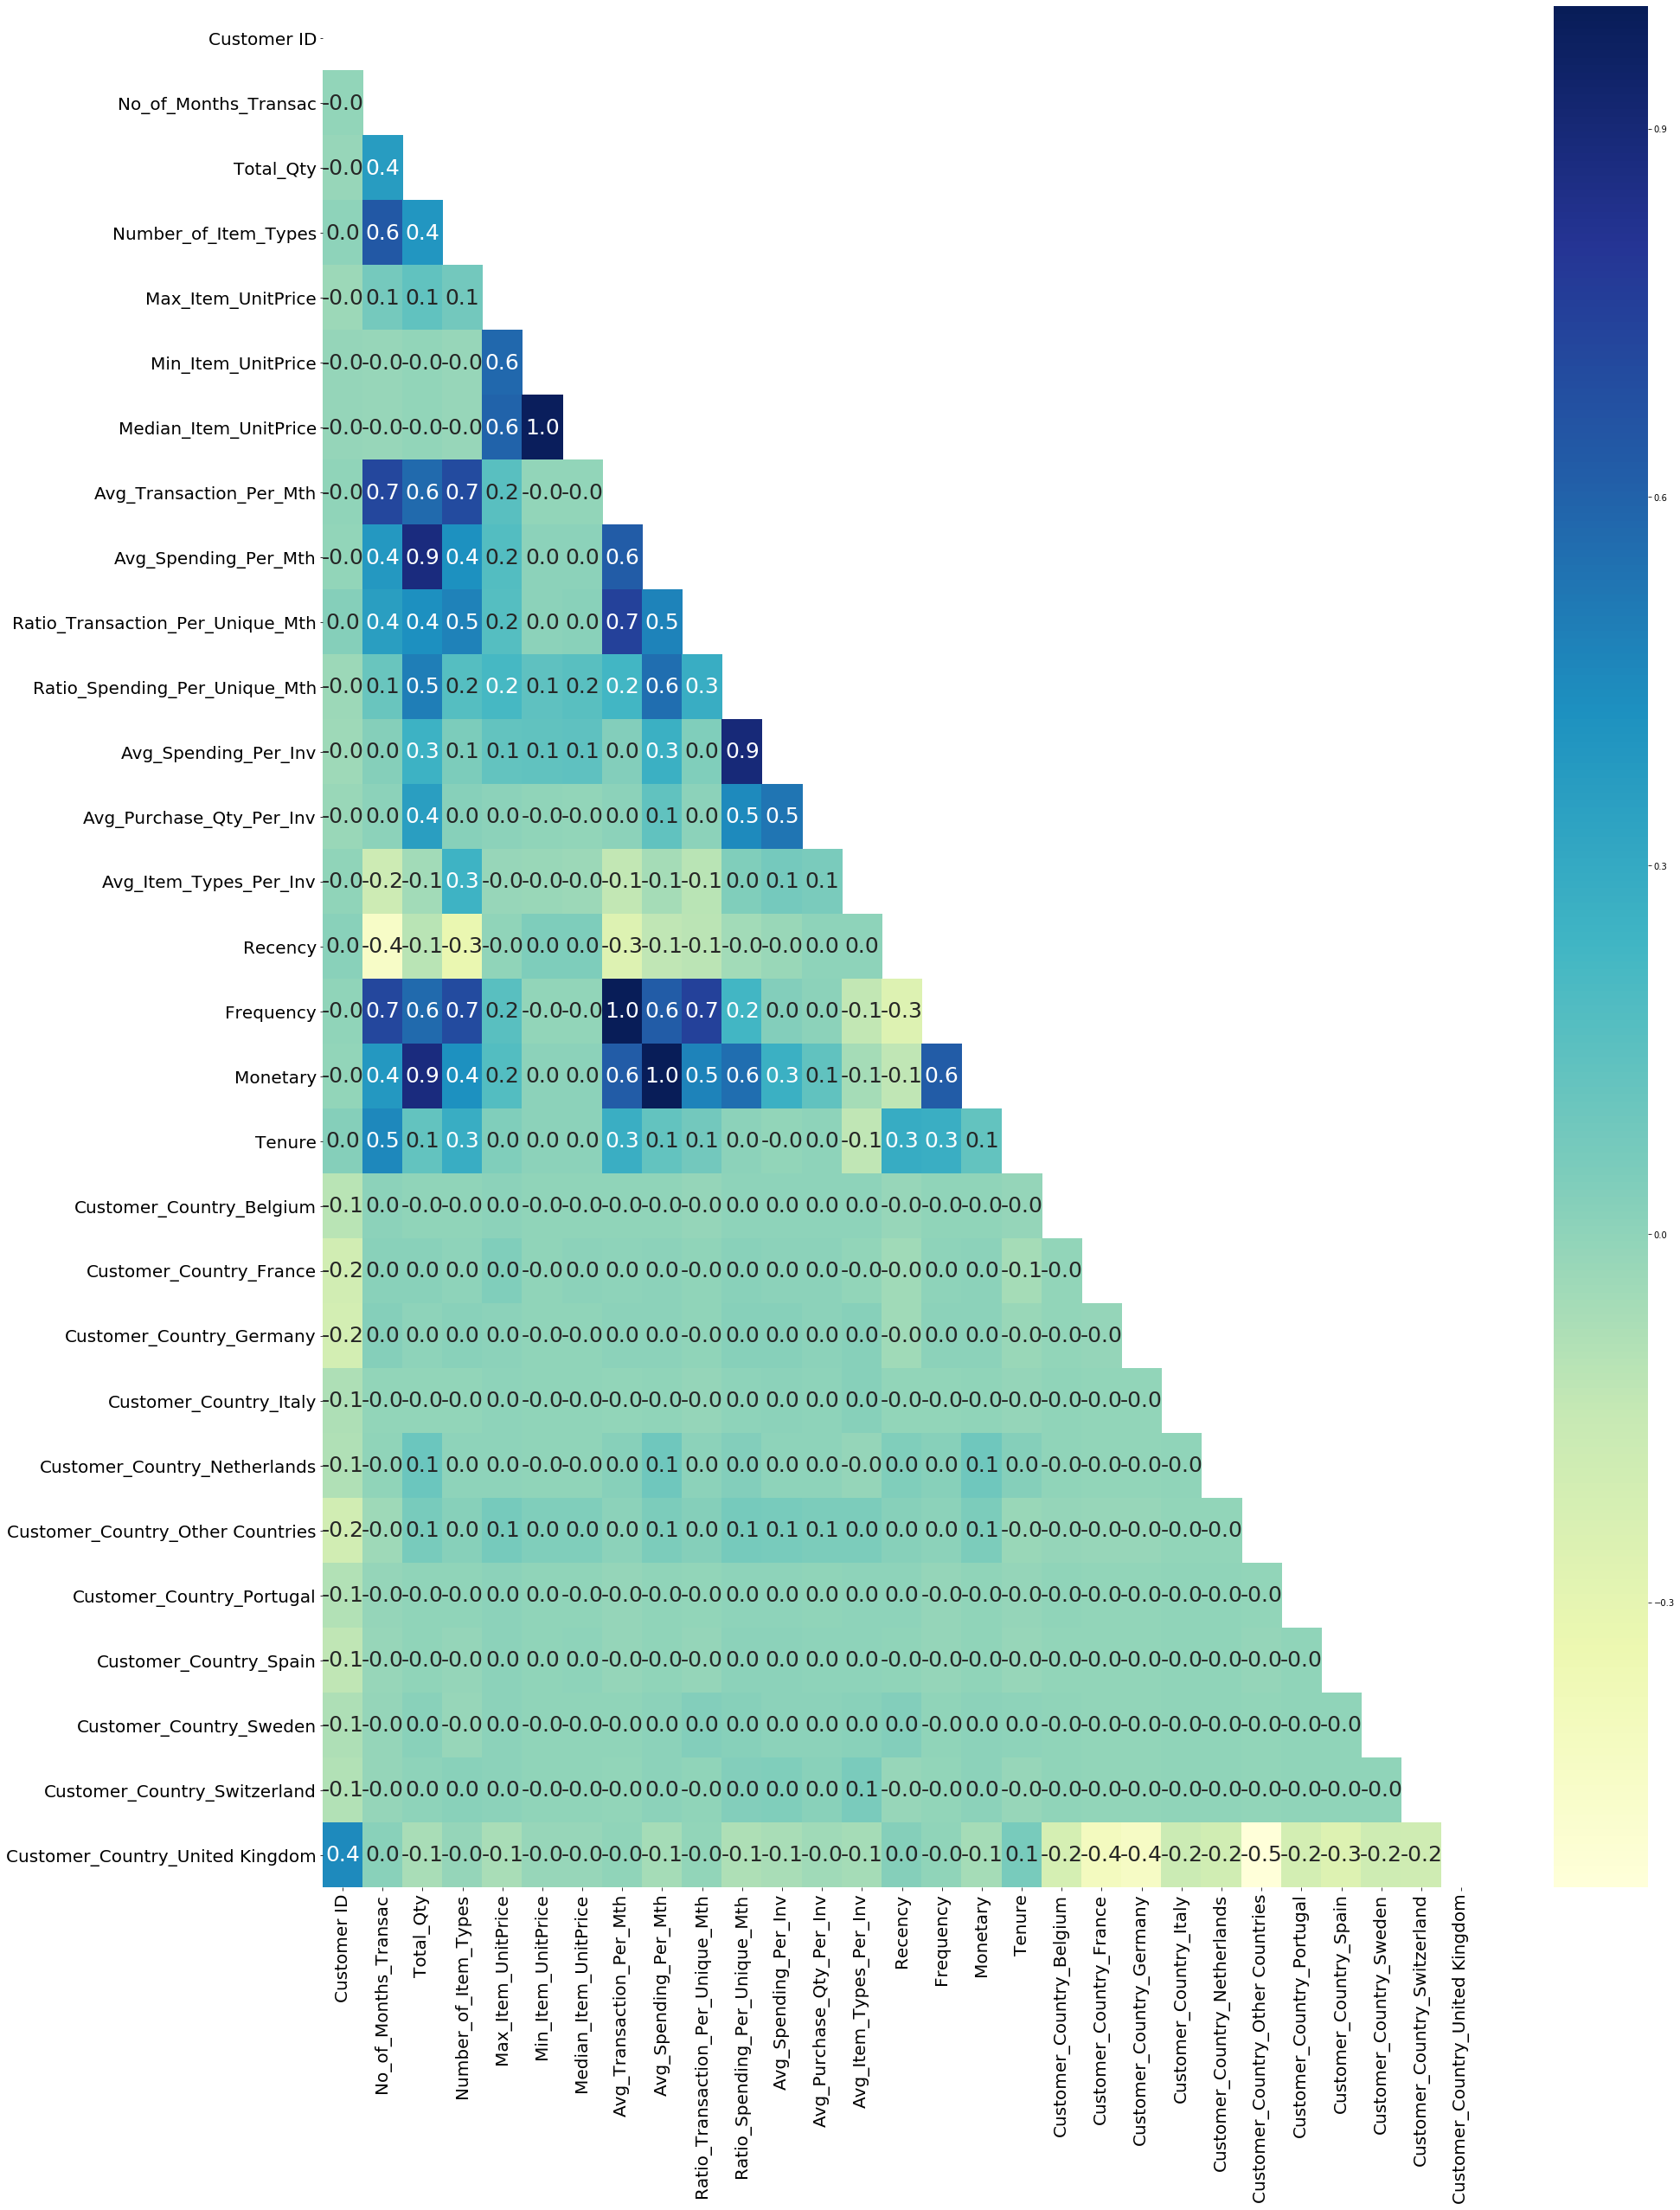

In [32]:
fix, ax = plt.subplots(figsize=(30,40))
mask = np.zeros_like(customer_feat.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(customer_feat.corr(), mask=mask, cmap='YlGnBu',ax=ax,annot=True,fmt='.1f',annot_kws={"size":25})
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=20,rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=20)
ax.yaxis.set_tick_params(rotation=360)

<font color=darkblue> When comparing correlation of 17 Customer Features (excluding Customer Country), the following has strong correlation.<br>
- Tenure, No_of_Months_Transac,Number_of_Item_Types<br>
- Monetary,Total_Qty,Ratio_Transaction_Per_Unique_Mth,Ratio_Spending_Per_Unique_Mth,Avg_Transaction_Per_Mth,
    Avg_Spending_Per_Mth,Frequency<br>
- Frequency,
No_of_Months_Transac,Total_Qty,Number_of_Item_Types,Ratio_Transaction_Per_Unique_Mth,Avg_Transaction_Per_Mth,Avg_Spending_Per_Mth<br>
- Avg_Spending_Per_Mth,Total_Qty,Ratio_Transaction_Per_Unique_Mth,Ratio_Spending_Per_Unique_Mth,Avg_Transaction_Per_Mth<br>
- Avg_Transaction_Per_Mth,No_of_Months_Transac,Total_Qty,Number_of_Item_Types,Ratio_Transaction_Per_Unique_Mth<br>
- Avg_Purchase_Qty_Per_Inv,Ratio_Spending_Per_Unique_Mth,Avg_Spending_Per_Inv<br>
- Avg_Spending_Per_Inv,Ratio_Spending_Per_Unique_Mth<br>
- Ratio_Spending_Per_Unique_Mth,Total_Qty<br>
- Ratio_Transaction_Per_Unique_Mth,Number_of_Item_Types<br>
- Median_Item_UnitPrice,Max_Item_UnitPrice,Min_Item_UnitPrice<br>
- Min_Item_UnitPrice,Max_Item_UnitPrice<br>
- Number_of_Item_Types,No_of_Months_Transac